# Generate simulation data for cSIM speckle

In [1]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import fft2, ifft2, fftshift, ifftshift

from IPython import display
import time
import pickle

from zernfun import zernfun, cart2pol


%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use(['dark_background'])

In [2]:
# Experimental parameters

lambda_c = 0.532           # coherent wavelength
mag = 20                   # system magnification
pscrop = 6.5/mag           # effective pixel size on camera plane
upsamp_factor = 1          # upsampling factor (should upsample to Nyquist of expected resolution)
NA_obj = 0.1               # Objective NA
NAs = 0.4                  # Speckle illumination NA
sp_factor = 4              # The ratio of size of the created speckle and the sample
N_bound_pad = 40           # Simulation for non-periodic boundary condition
z_camera = np.array([0,31.25]) # camera defocus


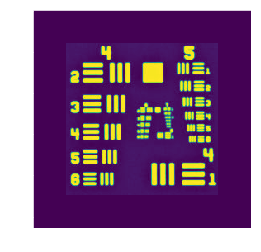

In [3]:
# Load simulation image

I = np.double(plt.imread('resolution.jpg'))
I = I[322:506,357:541,1]
I = np.pad(I/np.max(I),N_bound_pad,mode='constant')

plt.imshow(I)


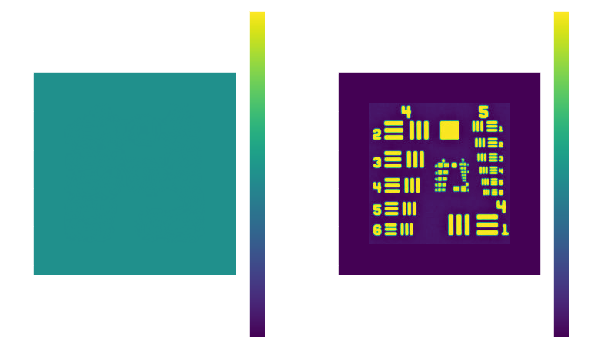

In [4]:
# Setup sample's transmittance function

amp = (1-I)+0.5
amp = amp/np.max(amp)
amp = np.ones_like(I)
ph = I.copy()

T_c = amp * np.exp(1j*ph)

fig,ax = plt.subplots(1,2,figsize=(10,6))
ax0 = ax[0].imshow(abs(T_c))
ax1 = ax[1].imshow(np.angle(T_c))
fig.colorbar(ax0,ax=ax[0])
fig.colorbar(ax1,ax=ax[1])


In [5]:
ps = pscrop/upsamp_factor
N, M = I.shape

Ncrop = N//upsamp_factor
Mcrop = M//upsamp_factor

# sample coordiante

x = np.r_[-M/2:M/2]*ps
y = np.r_[-N/2:N/2]*ps

fx = np.r_[-M/2:M/2]/ps/M
fy = np.r_[-N/2:N/2]/ps/N

NAx = fx*lambda_c
NAy = fy*lambda_c

fxx, fyy = np.meshgrid(fx,fy)

fxx = ifftshift(fxx)
fyy = ifftshift(fyy)

fr = (fxx**2 + fyy**2)**(1/2)

# speckle coordinate

xs = np.r_[-M*sp_factor/2:M*sp_factor/2]*ps
ys = np.r_[-N*sp_factor/2:N*sp_factor/2]*ps

fxs = np.r_[-M*sp_factor/2:M*sp_factor/2]/ps/M/sp_factor
fys = np.r_[-N*sp_factor/2:N*sp_factor/2]/ps/N/sp_factor

NAxs = fxs*lambda_c
NAys = fys*lambda_c

fxxs, fyys = np.meshgrid(fxs,fys)

fxxs = ifftshift(fxxs)
fyys = ifftshift(fyys)

frs = (fxxs**2 + fyys**2)**(1/2)


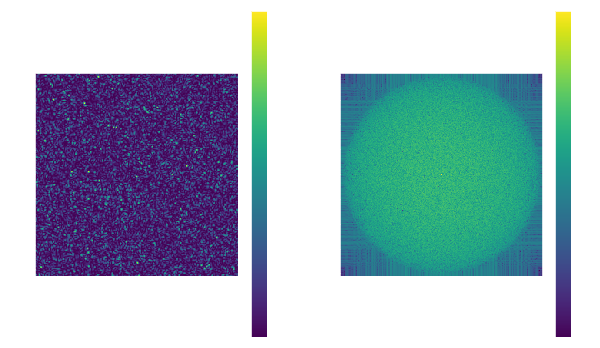

In [6]:
# Speckle field generation

np.random.seed(50)

Pupil_s = np.zeros((N*sp_factor,M*sp_factor))
Pupil_s[frs<NAs/lambda_c] = 1

random_phase = np.exp(1j*np.random.rand(N*sp_factor,M*sp_factor)*100)
speckle_field = ifft2(Pupil_s * random_phase)
speckle_field = speckle_field / np.max(abs(speckle_field))
speckle_intensity = abs(speckle_field)**2
speckle_intensity_crop = speckle_intensity[N*sp_factor//2-N//2:N*sp_factor//2+N//2,\
                                           M*sp_factor//2-M//2:M*sp_factor//2+M//2]
speckle_intensity_crop_f = fft2(speckle_intensity_crop)

fig,ax = plt.subplots(1,2,figsize=(10,6))
ax0 = ax[0].imshow(speckle_intensity_crop, extent=(np.min(x), np.max(x), np.min(y), np.max(y)))
ax1 = ax[1].imshow(fftshift(np.log10(abs(speckle_intensity_crop_f)/np.max(abs(speckle_intensity_crop_f)))), \
                   extent=(np.min(NAxs), np.max(NAxs), np.min(NAys), np.max(NAys)))
fig.colorbar(ax0,ax=ax[0])
fig.colorbar(ax1,ax=ax[1])

In [7]:
# Specify speckle scanning trajectory

N_shiftx = 24           # number of x translation
N_shifty = 24           # number of y translation
pixel_step = 2          # number of pixels per translation

Nimg = N_shiftx * N_shifty

pixel_shift_stack = np.zeros((2, Nimg),dtype='int')

if np.mod(N_shiftx,2) == 1:
    pixel_shiftx = (np.r_[0:N_shiftx]-(N_shiftx-1)/2)*pixel_step
else:
    pixel_shiftx = (np.r_[0:N_shiftx]-N_shiftx/2)*pixel_step


if np.mod(N_shifty,2) == 1:
    pixel_shifty = (np.r_[0:N_shifty]-(N_shifty-1)/2)*pixel_step
else:
    pixel_shifty = (np.r_[0:N_shifty]-N_shifty/2)*pixel_step

    
pixel_shiftxx, pixel_shiftyy = np.meshgrid(pixel_shiftx,pixel_shifty)
pixel_shift_stack[0] = pixel_shiftyy.flatten()
pixel_shift_stack[1] = pixel_shiftxx.flatten()

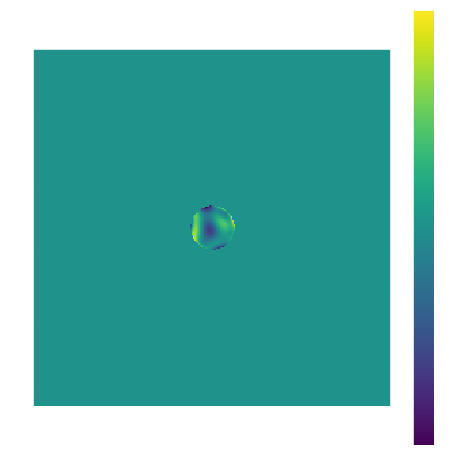

In [8]:
# Create Zernike polynomial for aberration simulation

n = np.array([2,2,2,3,3,3,3,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,6,6,6])
m = np.array([-2,0,2,-3,-1,1,3,-4,-2,-0,2,4,-5,-3,-1,1,3,5,-6,-4,-2,0,2,4,6])

N_poly = len(n)

zerpoly = np.zeros((N_poly,N,M))

[rr, theta_theta] = cart2pol(fxx/NA_obj*lambda_c,fyy/NA_obj*lambda_c)
idx = rr<=1

for i in range(0,N_poly):
    z = np.zeros_like(fxx)
    temp = zernfun(n[i],m[i],rr[idx],theta_theta[idx])
    z[idx] = temp.ravel()
    zerpoly[i] = z/np.max(z)
    
zern_para = np.random.randn(N_poly,1)*0.2
aberration = np.zeros((N,M))

for i in range(0,N_poly):
    aberration += zern_para[i]*zerpoly[i]

plt.figure(figsize=(8,8))
plt.imshow(fftshift(aberration))
plt.colorbar()


In [9]:
# Pupil and propagation function creation

Pupil_obj = np.zeros_like(I)
Pupil_obj[fr<NA_obj/lambda_c] = 1
Pupil_prop_sup = Pupil_obj.copy()

# Pupil_obj = Pupil_obj * np.exp(1j*aberration)

N_defocus = z_camera.shape[0]

Hz_det = np.zeros((N_defocus, N, M),complex)

for i in range(0, N_defocus):
    Hz_det[i] = Pupil_prop_sup * np.exp(1j*2*np.pi/lambda_c*z_camera[i]*\
                                        (1-lambda_c**2 * fr**2 *Pupil_prop_sup)**(1/2))


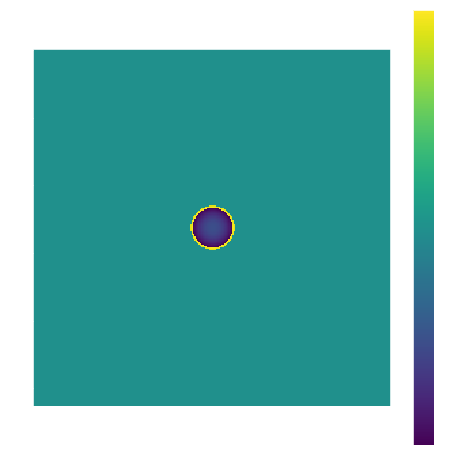

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(fftshift(np.angle(Hz_det[1])))
plt.colorbar()

In [11]:
# Data generation 

Nb = np.int(Ncrop - 2*N_bound_pad/upsamp_factor)
Mb = np.int(Mcrop - 2*N_bound_pad/upsamp_factor)

speckle_field_shift_crop = np.zeros((Nimg,N,M),dtype=complex)

Ic_image = np.zeros((N_defocus,Nimg,Nb,Mb))

for i in range(0,Nimg):

    speckle_field_shift_crop[i] = speckle_field[N*sp_factor//2-N//2+pixel_shift_stack[0,i]:\
                                                N*sp_factor//2+N//2+pixel_shift_stack[0,i],\
                                                M*sp_factor//2-M//2+pixel_shift_stack[1,i]:\
                                                M*sp_factor//2+M//2+pixel_shift_stack[1,i]]
    for j in range(0,N_defocus):
        Ic_tempf = fftshift(fft2(ifftshift(speckle_field_shift_crop[i] * T_c)) * Pupil_obj * Hz_det[j])
        Ic_temp = fftshift(ifft2(ifftshift(Ic_tempf[N//2-Ncrop//2:N//2+Ncrop//2,M//2-Mcrop//2:M//2+Mcrop//2])))
        Ic_image[j,i] = abs(Ic_temp[N_bound_pad//upsamp_factor:N_bound_pad//upsamp_factor+Nb,\
                          N_bound_pad//upsamp_factor:N_bound_pad//upsamp_factor+Mb])**2
    
    if np.mod(i+1,100) == 0 or i+1 == Nimg:
        print('Data generating process (%d / %d)'%(i+1,Nimg))

Data generating process (100 / 576)
Data generating process (200 / 576)
Data generating process (300 / 576)
Data generating process (400 / 576)
Data generating process (500 / 576)
Data generating process (576 / 576)


In [12]:
# Add noise to the measurement

photon_count = 3000
dark_current = 0

Ic_image = np.random.poisson(Ic_image/np.max(Ic_image) * photon_count + dark_current)

Ic_image = Ic_image.astype('float64')

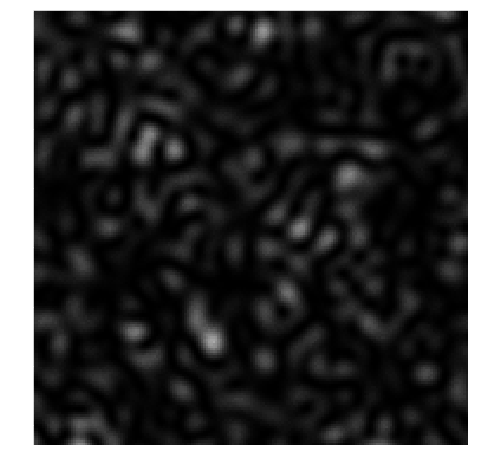

In [13]:
# Animate the image to check the simulated images

f1,ax = plt.subplots(1,1,figsize=(8,8))
max_val = np.max(Ic_image)

for i in range(0,40):
    if i != 1:
        ax.cla()
    ax.imshow(Ic_image[1,i],cmap='gray',vmin=0,vmax=max_val);
    display.display(f1);
    display.clear_output(wait=True);
    time.sleep(0.0001);

In [13]:
# Save the simulated dataset

f = open('res_speckle_shift.pckl', 'wb')
pickle.dump((pscrop,lambda_c,NA_obj,z_camera,Ic_image,upsamp_factor,dark_current,pixel_shift_stack,speckle_field_shift_crop), f)
f.close()